In [3]:
#*****Imports for dataprocessing********
import pandas as pd
import numpy as np
from numpy import array
import math
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from heapq import nsmallest
import scipy.optimize as sco
save_path = '/Users/antonerlandsson/Documents/Models'

#*****Imports for designing the LSTM model.******
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping

In [51]:
plt.style.use('seaborn')

## This code is splitted into multiple steps

1. We explain the how we choose the stocks that we wanted to include in our portfolio.
2. We get data from yahoo finance, process it and present it
3. Preparing the data for LSTM

## 1.

In [26]:
# Reading in a list of stocks from the NASDAQ largecap exchange. These are then filtered for time on the stoch exchange. 
stocks_raw = pd.read_csv('/mnt/c/Users/Anton/Dropbox/PythonProjects/Python Projects/Python in Financial Engineering/Project Work/largecap.csv', sep=';', encoding='latin-1', parse_dates = True, infer_datetime_format = True, index_col = 'listingdate')
stocks_filtered = stocks_raw[stocks_raw.index <= '2000-01-01'].copy()
stocks_filtered

,company,volume100d,sector,industry
listingdate,,,,
1999-06-22,ABB,"1411425,625",Industrials,Industrial Machinery
1994-11-08,Assa Abloy,"2023678,875",Industrials,Construction Supplies
1999-04-06,AstraZeneca,"501995,8438",Health Care,Pharmaceuticals
1973-01-01,Atlas Copco A,"1111550,5",Industrials,Industrial Machinery
1994-07-14,Atrium Ljungberg,"179766,4063",Financials,Real Estate
...,...,...,...,...
1989-07-03,SSAB B,"3446860,5",Materials,Mining - Steel & Aluminum
1997-01-02,Stora Enso A,"13966,51953",Materials,Forest & Wood Products
1998-08-24,Sweco A,"2118,939941",Industrials,Business Consultants


In [27]:
# Filtering for stocks that have a volume that is higher than the mean. This is to only get those stocks that are liquid
stocks_filtered['volume100d'] = stocks_filtered['volume100d'].str.replace(',', '.').astype(float)
stocks_filtered = stocks_filtered[stocks_filtered['volume100d'] >= stocks_filtered['volume100d'].mean()]
stocks_filtered

,company,volume100d,sector,industry
listingdate,,,,
1999-06-22,ABB,1411425.625,Industrials,Industrial Machinery
1994-11-08,Assa Abloy,2023678.875,Industrials,Construction Supplies
1973-01-01,Atlas Copco A,1111550.500,Industrials,Industrial Machinery
1985-01-01,Electrolux B,1247480.375,Consumer Durables,Consumer Electronics
1994-03-01,Elekta,1535047.875,Health Care,Medical Equipment
1976-01-01,Ericsson B,7240196.500,Technology,Communications
1995-06-08,Getinge,1074312.375,Health Care,Medical Supplies
1974-06-17,Hennes & Mauritz,4813372.000,Consumer Durables,Clothing & Footwear
1997-12-15,Nordea Bank,7857396.500,Financials,Banks


In [18]:
# Looking how many unique sectors there are. 

print(len(stocks_raw['sector'].unique()))
print(len(stocks_filtered['sector'].unique()))
len(stocks_filtered['sector'].unique()) / len(stocks_raw['sector'].unique())

9
7


0.7777777777777778

In [22]:
# Dropping the duplicates within industry and sector.

stocks_filtered_industry = stocks_filtered.drop_duplicates('industry')
stocks_filtered_sector = stocks_filtered.drop_duplicates('sector')
print(len(stocks_filtered_industry))
print(len(stocks_filtered_sector))

14
7


In [23]:
# Printing the results after removing duplicates. 

print(stocks_filtered_industry)
print(stocks_filtered_sector)

                      company   volume100d             sector  \
listingdate                                                     
1999-06-22                ABB  1411425.625        Industrials   
1994-11-08         Assa Abloy  2023678.875        Industrials   
1985-01-01       Electrolux B  1247480.375  Consumer Durables   
1994-03-01             Elekta  1535047.875        Health Care   
1976-01-01         Ericsson B  7240196.500         Technology   
1995-06-08            Getinge  1074312.375        Health Care   
1974-06-17   Hennes & Mauritz  4813372.000  Consumer Durables   
1997-12-15        Nordea Bank  7857396.500         Financials   
1987-01-01              SCA B  1765903.125          Materials   
1991-07-09          Securitas  1292955.250        Industrials   
1965-01-01            Skanska  1079145.125        Industrials   
1982-01-01              SKF B  1549650.250        Industrials   
1989-07-03             SSAB A  4616178.500          Materials   
1996-05-14            Tel

In [5]:
# Picking the stocks from the unique industry list as it gives a nice diversification.
tickers = ['ABB.ST', 'ASSA-B.ST', 'ELUX-B.ST', 'EKTA-B.ST', 'ERIC-B.ST', 'GETI-B.ST', 'HM-B.ST', 'NDA-SE.ST', 'SCA-B.ST', 'SECU-B.ST', 'SKA-B.ST', 'SKF-B.ST', 'SSAB-B.ST', 'TEL2-B.ST']

In [45]:
df = pdr.get_data_yahoo(tickers, start = '2000-01-01', end = '2020-12-10')['Close']
df = df.dropna()
df.head()

Symbols,ABB.ST,ASSA-B.ST,ELUX-B.ST,EKTA-B.ST,ERIC-B.ST,GETI-B.ST,HM-B.ST,NDA-SE.ST,SCA-B.ST,SECU-B.ST,SKA-B.ST,SKF-B.ST,SSAB-B.ST,TEL2-B.ST
Date,,,,,,,,,,,,,,
2012-06-18,112.599998,62.400002,127.900002,81.449997,63.299999,143.835999,226.399994,56.250000,21.233601,53.599998,99.699997,132.199997,34.571098,101.084000
2012-06-19,114.900002,62.866699,129.800003,81.050003,64.500000,143.673996,230.399994,57.799999,21.233601,54.049999,100.500000,134.500000,35.603901,102.625999
2012-06-20,115.099998,63.466702,136.300003,81.599998,64.800003,142.298004,241.500000,58.150002,21.233601,54.349998,101.900002,137.300003,36.622002,102.722000
2012-06-21,114.800003,63.366699,137.199997,81.849998,63.599998,141.246002,246.199997,57.650002,21.090900,53.849998,101.400002,135.100006,37.098000,99.734802
2012-06-25,109.900002,62.400002,133.000000,79.500000,62.000000,140.113007,242.300003,56.400002,20.601299,52.450001,98.900002,129.500000,34.651699,99.445702


In [62]:
# We compute the log-return correlation matrix. 

logReturn = np.log(df/df.shift(1))
corr_matrix = logReturn.corr()
corr_matrix_box_mean = corr_matrix.mean()
print(corr_matrix)

Symbols      ABB.ST  ASSA-B.ST  ELUX-B.ST  EKTA-B.ST  ERIC-B.ST  GETI-B.ST  \
Symbols                                                                      
ABB.ST     1.000000   0.551133   0.450056   0.309828   0.408138   0.278441   
ASSA-B.ST  0.551133   1.000000   0.412301   0.291934   0.365384   0.330482   
ELUX-B.ST  0.450056   0.412301   1.000000   0.230915   0.287909   0.251236   
EKTA-B.ST  0.309828   0.291934   0.230915   1.000000   0.215705   0.266704   
ERIC-B.ST  0.408138   0.365384   0.287909   0.215705   1.000000   0.250783   
GETI-B.ST  0.278441   0.330482   0.251236   0.266704   0.250783   1.000000   
HM-B.ST    0.395156   0.406861   0.361358   0.242273   0.270380   0.154107   
NDA-SE.ST  0.536900   0.473044   0.415614   0.242199   0.367478   0.229671   
SCA-B.ST   0.466167   0.444881   0.380658   0.296256   0.363928   0.288879   
SECU-B.ST  0.501598   0.538117   0.391645   0.280789   0.345475   0.254558   
SKA-B.ST   0.557000   0.538289   0.413516   0.285710   0.353931 

In [50]:
# We look at the mean correlation between the assets
print(corr_matrix_box_mean)

Symbols
ABB.ST       0.493046
ASSA-B.ST    0.473290
ELUX-B.ST    0.404159
EKTA-B.ST    0.312036
ERIC-B.ST    0.371103
GETI-B.ST    0.301572
HM-B.ST      0.391578
NDA-SE.ST    0.454022
SCA-B.ST     0.423918
SECU-B.ST    0.452143
SKA-B.ST     0.477824
SKF-B.ST     0.474533
SSAB-B.ST    0.410372
TEL2-B.ST    0.344129
dtype: float64


In [51]:
# We look at the assets which had the smallest mean correlation between eachother.

print(nsmallest(6, corr_matrix_box_mean))
print('[SKA-B.ST,            EKTA-B.ST,           GETI-B.ST,           ERIC-B.ST,         TEL2-B.ST,         HM-B.st            ]')

[0.3015719006389189, 0.31203558161164124, 0.344129426140454, 0.3711031739792328, 0.3915780588071901, 0.404158515591401]
[SKA-B.ST,            EKTA-B.ST,           GETI-B.ST,           ERIC-B.ST,         TELE2-B.ST,         HM-B.st            ]


## 2. 

In [15]:
tickers = ['SKA-B.ST', 'EKTA-B.ST', 'GETI-B.ST', 'ERIC-B.ST', 'TEL2-B.ST', 'HM-B.ST']
#stock_data = ext_datareader(tickers, start='2014-10-01', end='2020-10-01')

In [474]:
stock_data.head()

Asset,SKA,EKTA,GETI,ERIC,TEL2,HM
2014-10-01,145.800003,70.550003,146.425995,90.400002,83.064201,294.500000
2014-10-02,144.600006,71.250000,145.455002,89.250000,81.811501,288.399994
2014-10-03,147.699997,71.050003,147.559998,90.599998,82.486000,291.000000
2014-10-06,146.600006,71.000000,148.044998,89.500000,83.256897,290.500000
2014-10-07,144.800003,70.500000,147.317001,86.849998,82.486000,286.200012


### Portfolio class
We create a class because we need the stock-data from every asset within our portfolio. By storing the dowloaded data within the object, we only need to specify our portfolio once, then we can train a model on every individual asset by iterating over the TrainModel method.

In [6]:
class Portfolio(object):
    def __init__(self, tickers, start, end):
        self.tickers = tickers
        self.start = start
        self.end = end
        self._data = self.ext_datareader() # Runs the ext_datareader when we initialize the data_reader
        
        
    def ext_datareader(self):
        """Converts pandas-datareader yahoo data to a cleaner format.
        Parameters
        ----------
        raw_data : pd.DataFrame
            Rows represents different timestamps stored in index. Note that there can be gaps. Columns are pd.MultiIndex
            with the zero level being assets and the first level indicator.
        Returns
        -------
        df : pd.DataFrame
            A cleaned pd.DataFrame.

        """
        df = pdr.get_data_yahoo(self.tickers, self.start, self.end)
        df = df.drop(['High', 'Low', 'Open', 'Volume'], axis=1, level=0) # drops the columns we don't need
        df.index.name = None # removes the date index
        df = df.swaplevel(0, 1, axis=1) # swaps the multiindex
        df.columns.rename(names = ['Asset', 'Channel'], inplace = True)

        #_list = df.columns.levels[0].tolist()
        #new_list = [_list[i][:-5] for i in range(len(_list))]
        #df.columns.set_levels(new_list , level=0, inplace=True)
        df.replace(0, np.nan, inplace=True)
        #df = df.droplevel(level=1, axis=1)
        df.to_csv('/mnt/c/Users/Anton/Documents/Models/portfolio.csv')
        print('Tickers read...')
        print(f'You have {df.columns.levels[0].tolist()} in your portfolio')
        return df.interpolate().dropna()
    
    def TrainModel(self, stock, split_ratio = 0.8, batch_size = 5, look_back = 40, epochs = 50, save_graph=True):
        """Trains a univariate LSTM model with the input given.
        Parameters
        ----------
        stock : pd.DataFrame
            Pandas DataFrame containing stock prices ["Close"] and ['Adj Close'].
        split_ratio : float
            How the data should be splitted for testing and training. Default is 80 % training and 20 % testing.
        batch_size : integer
            How many batches the model should be trained with. 
        look_back : integer
            How many days in the past the model should use to predict the next days stock price.
        epochs : integer
            How many times the model will iterate every batch_size.
        save_graph : bool
            True if we want to save the loss and validation graphs for every trained model. False if we don't want to save. 
            
        Returns
        -------
        model : tf.keras.Model
            Returns a tf/keras object which has been trained and can be used for predictions.
        X_test : ndarray shape (Sample,Timestep,Features)
            Contains the test data for prediction.
        y_test : ndarray shape (Sample,Timestep,Features)
            Validation data
        scaler : sklearn.MinMaxScaler object
            A scaler that is unique for every inputted stock. Used to reverse MinMax scaling after prediction. 
        """
        
        # Load the data from the pd.DataFrame
        data = self._data[stock].filter(['Adj Close'])
        dataset = data.values
        training_data_len = math.ceil(len(dataset) * split_ratio)
        scaler = MinMaxScaler(feature_range=(0, 1)) # Transforms features by scaling each feature to a given range
        scaled_data = scaler.fit_transform(dataset)
        
        # Divide the data into training and testing data. Default split ratio is 0.8
        X, y = self.processData(scaled_data, look_back)
        X_train, X_test = X[:int(X.shape[0] * split_ratio)], X[int(X.shape[0] * split_ratio):]
        y_train, y_test = y[:int(y.shape[0] * split_ratio)], y[int(y.shape[0] * split_ratio):]
        pd.DataFrame(X_train).to_csv(f'/mnt/c/Users/Anton/Documents/Models/Train Data/{stock}-X_train.csv', index=False)
        pd.DataFrame(X_test).to_csv(f'/mnt/c/Users/Anton/Documents/Models/Test Data/{stock}-X_test.csv', index=False)
        pd.DataFrame(y_train).to_csv(f'/mnt/c/Users/Anton/Documents/Models/Train Data/{stock}-y_train.csv', index=False)
        pd.DataFrame(y_test).to_csv(f'/mnt/c/Users/Anton/Documents/Models/Test Data/{stock}-y_test.csv', index=False)
        
        #Reshape data for (Sample,Timestep,Features) Has to be done because the models are very sensitive to input-shape
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1] ,1))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
        
        # Create the model
        callback = EarlyStopping(monitor='loss', patience=3) # specifying that the training should early stop when the loss has not decreased in three ephocs.
        model = self.model(look_back = look_back)
        history = model.fit(X_train, y_train, epochs=epochs, 
                            validation_data = (X_test,y_test), 
                            shuffle=True, batch_size = batch_size, callbacks = [callback]) # training/fitting the model with the previous data
        
        # ** Saving model-data **
        model.save(f'/mnt/c/Users/Anton/Documents/Models/{stock}')
        
        if save_graph == True:
            fig = plt.figure()
            plt.title(f'Loss of {stock}')
            plt.xlabel('Epochs', fontsize=14)
            plt.ylabel('Loss', fontsize=14)
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.legend(['loss', 'val_loss'], loc='upper right')
            plt.savefig(f'/mnt/c/Users/Anton/Documents/Models/{stock}/{stock}-loss.png')
            plt.close(fig)
        return model, X_test, y_test, scaler
    
        #           ** Creating the LSTM network that is used for training. **
    
    def model(self, look_back): 
        """Builds a model for every single stock. Gives the possibility to tweak the architecture of the model for indivudual assets. 
        
        LAYER 1 : LSTM: 52 neurons
        LAYER 2 : LSTM: 52 neurons
        LAYER 3 : DENSE : 25 neurons
        LAYER 4 ( OUTPUT ) : 1 neuron
        
        Optimizer for gradient decent is adam.
        Loss is measured with Mean Squared Error.
        
        Parameters
        ----------
        look_back : pd.DataFrame
            How many days in the past the model should use to predict the next days stock price.
        Returns
        -------
        _model : tf.keras.Model
            An LSTM model that can be trained on given a certain look_back period. 
        """
        _model = Sequential() # calls on the basemodel Sequential() from the keras library. Used for one input one output models.
        _model.add(LSTM(52, return_sequences=True, input_shape=(look_back , 1))) # return_sequence has to be true when using multiple LSTM layers
        _model.add(LSTM(52, input_shape=(look_back , 1)))
        _model.add(Dense(25))
        _model.add(Dense(1))
        _model.compile(optimizer='adam', loss='mse')
        return _model

    def processData(self, data, look_back):
        """ Method that processes/splits data into according shape/size. 
        Parameters
        ----------
        data : pd.DataFrame
            Cointains stockdata that has been MinMax scaled
        
        Returns
        -------
        array(X) : ndarray shape (Scaled data, look_back, 0)
            Array of data that has been splitted.
        array(Y) : ndarray shape (Scaled data, look_back, 0)
            Array of data that has been splitted. 
        """
        X , Y = [] , []
        for i in range(len(data) - look_back - 1): # the range of the data that will be used for the model. -look_back and -1 for offsetting it.
            X.append(data[i:(i + look_back),0])
            Y.append(data[(i + look_back),0])
        return array(X) , array(Y)
    
    @staticmethod
    def plotter(stock, model, x_test, y_test, scaler):
        """ Method that saves the loss-plots 
        
        """
        Xt = model.predict(x_test)
        fig = plt.figure(figsize=(16,8))
        plt.title(f'LSTM model for {stock}')
        plt.xlabel('Date', fontsize=18)
        plt.ylabel('Adj Close Price SEK', fontsize=18)
        plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)))
        plt.plot(scaler.inverse_transform(Xt))
        plt.legend(['Val', 'Predictions'], loc='lower right')
        plt.savefig(f'/mnt/c/Users/Anton/Documents/Models/{stock}/{stock}-model_graph.png')
        plt.close(fig)
    
    @staticmethod
    def pred_act(x_test, scaler, y_test, model):
        """Method that saves the predicted and actual stockprices into csv files. Index [-1] is the "real" predicted price.
        """
        act = []
        pred = []
        for i in range(294):
            Xt = model.predict(x_test[i].reshape(1,40,1)) # predict the stockprices at every i
            pred.append(scaler.inverse_transform(Xt)) # using scaler.inverse to reverse the previous scaled data back to stock prices
            act.append(scaler.inverse_transform(y_test[i].reshape(-1,1))) # using scaler.inverse to reverse the previous scaled data back to stock prices
        pred = np.array(pred).flatten() # flattening the array to be 1-dimension. 
        act = np.array(act).flatten()
        df_pred = pd.DataFrame(columns = tickers) # creating a pandas DataFrame that has tickers as column-names.
        df_act = pd.DataFrame(columns = tickers)
        df_pred[stock] = pred # appending data to the given stock. 
        df_act[stock] = act
        df_pred.to_csv(f'/mnt/c/Users/Anton/Documents/Models/{stock}/{stock}-pred.csv', index=False)
        df_act.to_csv(f'/mnt/c/Users/Anton/Documents/Models/{stock}/{stock}-actual.csv', index=False)
        return act, pred

In [304]:
# constructs/initialize the portfolio. this loads all the data for the stocks within the portfolio. tickers are given since before.
portfolio = Portfolio(tickers, start = '2013-10-01', end = '2020-10-01')

Tickers read...
You have ['SKA-B.ST', 'EKTA-B.ST', 'GETI-B.ST', 'ERIC-B.ST', 'TEL2-B.ST', 'HM-B.ST'] in your portfolio


In [305]:
# Iterating through all of our stocks we have in our portfolio. each loop trains the model and validates 
# it to it's corresponding test-set. Loss, validation and fit is plotted in graphs and saved in a 
# directory. RMSE is also computed and saved as a text file. 

for stock in tickers:
    model, x_test, y_test, scaler = portfolio.TrainModel(stock) # trains the model for the specific stock.
    portfolio.plotter(stock, model, x_test, y_test, scaler) # calls on the plotter method to save graohs
    act, prediction = portfolio.pred_act(x_test, scaler, y_test, model) # calls on the pred_act method which saves the predicted and actual price into csv
    rmse = np.sqrt(np.mean(((prediction - act)**2))) # computes the rmse of every validated model 
    with open (f'/mnt/c/Users/Anton/Documents/Models/{stock}/{stock}-rmse.txt','w') as f: # saves the rmse into .txt file.
               f.write(str(rmse)+'\n')

Epoch 1/50
275/275 [==============================] - 8s 27ms/step - loss: 0.0018 - val_loss: 0.0033
Epoch 2/50
275/275 [==============================] - 7s 24ms/step - loss: 9.3786e-04 - val_loss: 0.0039
Epoch 3/50
275/275 [==============================] - 7s 25ms/step - loss: 6.9316e-04 - val_loss: 0.0025
Epoch 4/50
275/275 [==============================] - 7s 25ms/step - loss: 6.2064e-04 - val_loss: 0.0016
Epoch 5/50
275/275 [==============================] - 7s 25ms/step - loss: 5.4043e-04 - val_loss: 0.0013
Epoch 6/50
275/275 [==============================] - 7s 24ms/step - loss: 4.7188e-04 - val_loss: 0.0012
Epoch 7/50
275/275 [==============================] - 7s 24ms/step - loss: 4.8699e-04 - val_loss: 0.0014
Epoch 8/50
275/275 [==============================] - 7s 25ms/step - loss: 3.7723e-04 - val_loss: 8.4694e-04
Epoch 9/50
275/275 [==============================] - 7s 25ms/step - loss: 3.6925e-04 - val_loss: 0.0012
Epoch 10/50
275/275 [==============================] - 

## 3.

In [7]:
# creates a function that loops over the stocks in the portfolio and reads in the stocks actual / predicted data.
tickers = ['SKA-B.ST', 'EKTA-B.ST', 'GETI-B.ST', 'ERIC-B.ST', 'TEL2-B.ST', 'HM-B.ST']
def concat_df(type_ = ''):
    df = pd.DataFrame(columns = tickers)
    for stock in tickers:
        df[stock] = pd.read_csv(f'{save_path}/{stock}/{stock}-{type_}.csv')[stock]
    return df

In [8]:
actual = concat_df(type_ = 'actual') # saves the portfolio stocks actual stock price in a dataframe
unknown_price = actual.iloc[-1] # allocates the real price that is unknown to the model into a variable. comparable price
actual = actual[:-1] # all the real stock prices to day t
actual_last = actual.iloc[-1] # getting the time t stock price. 

In [9]:
actual_ret = (unknown_price - actual_last) / actual_last

In [10]:
predicted = concat_df(type_='pred') # saves the potfolio stocks predicted stock price in a dataframe
pred_price = predicted.iloc[-1] # the t+1 stock price

In [11]:
# the returns should probably be calculated as log_return. it however complicates the caluculation of the return for t+1 thus normal return has been calculated.
# just showing below how the log returns and covariance matrix with log can be calulated.

#log_actual = np.log(actual / actual.shift(1))
#log_actual_price = log_actual.iloc[-2]
#test_cov = log_actual.cov() # testing cov of actual
#log_pred = np.log(predicted / predicted.shift(1))
#log_pred_price = log_pred.iloc[-1]

### Calulating the return for t --> t+1 with the predicted price at t+1

$E(R_{A})_{t+1}^{} = \frac{PP_{t+1}^{A} - P_{t}^{A}}{P_{t}^{A}}$

$E(R_{A})_{t+1}^{}$ = unweighted expected return of a single asset at time t+1

$PP_{t+1}^{A}$ = predicted for a specific asset price at t+1

$P_{t}^{A}$ = real price of asset at time t


In [12]:
# calculating the returns of all the stocks in our portfolio. this is done with the do

def calc_return():
    returns = [] 
    
    for stock in tickers:
        returns.append((pred_price[stock] - actual_last[stock]) / actual_last[stock]) 
        
    df = pd.Series(returns, index = tickers, name = 'Predicted returns')
    return df

In [13]:
pred_ret = calc_return()

In [14]:
# the means/expected returns for t+1
pred_ret

SKA-B.ST     0.003109
EKTA-B.ST    0.016434
GETI-B.ST   -0.005667
ERIC-B.ST   -0.000773
TEL2-B.ST    0.017092
HM-B.ST      0.006105
Name: Predicted returns, dtype: float64

### Calculating covariance matrix of portfolio

$cov(X, Y) = \sum_{i = 0}^{N} = \frac{(R_{X_{i}}-\bar{R}_{X})-(R_{Y_{i}}-\bar{R}_{Y})}{N - 1}$

In [15]:
# defining a function that returns the covariance matrix of all the assets.

def covariance_matrix(bias = False):
    matrix = np.zeros([len(tickers), len(actual) - 1])
    i = 0
    for stocks in tickers: # iterating over both the stocks and the created matrix.
        numerator = actual[stocks].pct_change().dropna() - pred_ret[stocks] # calculating the numerator of the function. subtracting the predicted mean/return.
        matrix[i] = numerator # adding the numerator to the previos created matrix.  
        i += 1
    daily_cov = np.cov(matrix, bias = bias) # using np.cov to compute the coveriance matrix of the whole portfolio. bias is used for N - 1.
    print('Daily covariance for the portfolio stocks are: ')
    print('')
    print(pd.DataFrame(daily_cov, columns=[tickers], index=[tickers]))
    return daily_cov

In [16]:
daily_cov = covariance_matrix()

Daily covariance for the portfolio stocks are: 

           SKA-B.ST EKTA-B.ST GETI-B.ST ERIC-B.ST TEL2-B.ST   HM-B.ST
SKA-B.ST   0.000451  0.000248  0.000096  0.000221  0.000157  0.000355
EKTA-B.ST  0.000248  0.000879  0.000184  0.000216  0.000113  0.000349
GETI-B.ST  0.000096  0.000184  0.000626  0.000200  0.000142  0.000026
ERIC-B.ST  0.000221  0.000216  0.000200  0.000591  0.000185  0.000252
TEL2-B.ST  0.000157  0.000113  0.000142  0.000185  0.000316  0.000165
HM-B.ST    0.000355  0.000349  0.000026  0.000252  0.000165  0.000823


### Optimizing portfolio with markowitz

We create a class that will be used for optimizing the portfolio using Markowitz strategy. The class has methods that can be used to optimize the portfolio for maximum sharpe ratio and minimum variance. There are also methods for benchmarking the predicted returns from the LSTM model. 

These are 1overN which is a simple weight allocation of 1 / number of assets, giving a equal distribution of weights between the assets. 

The other one is a random optimizer which only takes random weights from a normal distribution which has to add up to one and allocates these weights to the different assets in the portfolio. 

There is also a method for plotting the efficient frontier of the different allocations. This is based on Monte-Carlo simulation. It's only used for visualization.  

Unfortunately, we didn't manage to compute a minimum variance portfolio. No matter what we did, the weights were always the same as the initial guess. It might have something to do with that the portfolio volatity and returns is not scaled to 256 days(1 year). This makes the covariances extremely small and there is probably a very small difference in volatility between different portfolios. 

In [20]:
class portfolio_optimizer(object):
    def __init__(self, mean, daily_cov, log_ret = False):
        self.cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1}) # setting up the constraint for the opmitization. total sum of weights can only be 1
        self.bnds = tuple((0, 1) for x in range(len(tickers)))
        self.initialGuess = np.ones(len(tickers))*(1./len(tickers)) # intital guess of weights for the optimizer to start from
        self.mean = mean # the calculated means/returns from the assets between t --> t+1
        self.daily_cov = daily_cov # the calculated covariance from the portfolio
        
    # method that returns the portfolio returns, volatility and sharpe-ratio given inputted weights. 
    def portfolio_stats(self, weights):
        weights = np.array(weights)
        pret = np.sum(self.mean * weights) # portfolio returns 
        pvol = np.sqrt(np.dot(weights.T, np.dot(self.daily_cov, weights))) # portfolio volatility
        return np.array([pret, pvol, pret / pvol])
    
    # function that returns weights for a minimized negative sharpe ratio
    def min_func_sharpe(self, weights):
        return -self.portfolio_stats(weights)[2]
    
    # function that returns weights for a minimized variance
    def min_func_variance(self, weights):
        return self.portfolio_stats(weights)[1] ** 2
    
    # function that return weights for portfolios with least standard devation
    def min_func_port(self, weights):
        return self.portfolio_stats(weights)[1]
    
    # method that minimizes the negative sharpe and variance. 
    def optimizer(self, no_info = False):
        max_sharpe = sco.minimize(self.min_func_sharpe, self.initialGuess, method='SLSQP',
                       bounds=self.bnds, constraints=self.cons)
        min_variance = sco.minimize(self.min_func_variance, self.initialGuess, method='SLSQP',
                       bounds=self.bnds, constraints=self.cons)
        
        if no_info == False:
            print(f"Max Sharpe {max_sharpe['message']}")
            print('')
            print('The return, volatility and Sharpe-Ratio are:', self.portfolio_stats(max_sharpe['x']).round(3))
            print('')
            print(pd.DataFrame(max_sharpe['x'].round(3), index=[tickers], columns = ['Maximum Sharpe Weights']))
            print('')
            print(f"Min Variance {min_variance['message']}")
            print('')
            print('The return, volatility and Sharpe-Ratio are:', self.portfolio_stats(min_variance['x']).round(3))
            print('')
            print(pd.DataFrame(min_variance['x'].round(3), index=[tickers], columns = ['Minimum Variance Weights']))
        else:
            pass
        return self.portfolio_stats(max_sharpe['x'].round(3))
    
    def one_over_n(self, no_info = False):
        """
        Simple N over 1 allocation to benchmark the deep-learning performance with
        
        Returns: return, volatility and sharpe ratio
        """
        weights = np.ones(len(tickers)) * (1./len(tickers))
        if no_info == False:
            print('The return, volatility and Sharpe-Ratio are:', self.portfolio_stats(weights.round(3)))
            print('')
        else:
            pass
        return self.portfolio_stats(weights)
    
    def random_optimizer(self, no_info = False):
        """
        Creates a random weight allocation of the portfolio without any knowledge about the past, present
        or future. Returns the return, volatity and sharpe ratio. 
        """
        np.random.seed(200)
        weights = np.random.random(len(tickers))
        weights /= np.sum(weights)
        if no_info == False:
            print('The return, volatility and Sharpe-Ratio are:', self.portfolio_stats(weights.round(3)))
            print('')
        else:
            pass
        return self.portfolio_stats(weights)

    
    def graph_efficient_frontier(self):
        """
        Monte Carlo Simulation in order to produce a efficient frontier. The same structure as above
        methods. 
        
        """
        
        max_sharpe = sco.minimize(self.min_func_sharpe, self.initialGuess, method='SLSQP',
                       bounds=self.bnds, constraints=self.cons)
        max_ret = self.portfolio_stats(max_sharpe['x'])[0]
        print(max_ret)
        trets = np.linspace(0.004, max_ret, 50)  
        tvols = []
        for tret in trets:
            cons = ({'type': 'eq', 'fun': lambda x:  self.portfolio_stats(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
            res = sco.minimize(self.min_func_port, self.initialGuess, method='SLSQP',
                       bounds=self.bnds, constraints=cons)
    
            tvols.append(res['fun']) #the value of the objective, i.e. standard deviation of portfolio returns
        tvols = np.array(tvols)
        
        # prepare lists for portfolio returns and volatilities
        prets = []
        pvols = []
        pSharpe =[]

        # randomly generate 2500 portfolios
        for p in range (2500):
            weights = np.random.random(len(tickers))
            weights /= np.sum(weights)
        
            # portfolio return
            ret = np.sum(self.mean * weights)
            #portfolio volatility
            vol = np.sqrt(np.dot(weights, 
                        np.dot(self.daily_cov, weights.T)))
       
            prets.append(ret)       
            pvols.append(vol)
            #portfolio Sharpe ratio
            sharpe = ret/vol
            pSharpe.append(sharpe)
            
        plt.figure(figsize=(8, 4))
        plt.scatter(pvols, prets, pSharpe, marker='o')
            # random portfolio composition
        plt.scatter(tvols, trets, c = trets/tvols, marker='x')
            # efficient frontier
        plt.plot(self.portfolio_stats(max_sharpe['x'])[1], self.portfolio_stats(max_sharpe['x'])[0],'r*', markersize=15.0)
            # portfolio with highest Sharpe ratio
        #plt.plot(portfolio_stats(optv['x'])[1], portfolio_stats(optv['x'])[0],
        #         'y*', markersize=15.0)
            # minimum variance portfolio
        plt.grid(True)
        plt.xlabel('Portfolio Standard Deviation')
        plt.ylabel('Expected Return')
        plt.colorbar(label='Sharpe ratio')
        plt.title('Efficient frontier for deep-learning')

In [21]:
pred_portfolio = portfolio_optimizer(pred_ret, daily_cov)

0.016960824044488308


/Users/antonerlandsson/.local/lib/python3.8/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


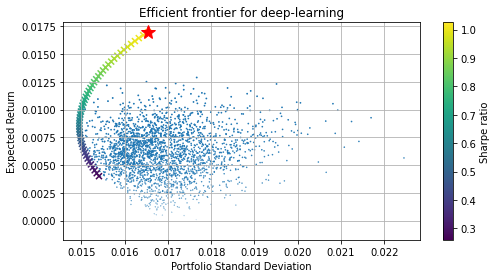

In [23]:
pred_portfolio.graph_efficient_frontier()

In [22]:
deep_learning = pred_portfolio.optimizer()

Max Sharpe Optimization terminated successfully

The return, volatility and Sharpe-Ratio are: [0.017 0.017 1.025]

           Maximum Sharpe Weights
SKA-B.ST                    0.000
EKTA-B.ST                   0.199
GETI-B.ST                   0.000
ERIC-B.ST                   0.000
TEL2-B.ST                   0.801
HM-B.ST                     0.000

Min Variance Optimization terminated successfully

The return, volatility and Sharpe-Ratio are: [0.006 0.016 0.372]

           Minimum Variance Weights
SKA-B.ST                      0.167
EKTA-B.ST                     0.167
GETI-B.ST                     0.167
ERIC-B.ST                     0.167
TEL2-B.ST                     0.167
HM-B.ST                       0.167


### Graphs of the performance of the LSTM prediction when applied to portfolio optimization

In [24]:
deeplearning = pred_portfolio.optimizer(no_info=True)

In [73]:
one_over_n = pred_portfolio.one_over_n(no_info=False)

The return, volatility and Sharpe-Ratio are: [0.00606205 0.01628103 0.37233783]



In [72]:
random_weights = pred_portfolio.random_optimizer(no_info=False)

The return, volatility and Sharpe-Ratio are: [0.00540843 0.01537108 0.35185777]



In [76]:
df1 = pd.DataFrame([deeplearning, one_over_n, random_weights], 
                  columns = ['Returns', 'Volatility', 'Sharpe-Ratio'], 
                  index = ['Deeplearning', 'One over N', 'Random Weights'])

In [77]:
df1

,Returns,Volatility,Sharpe-Ratio
Deeplearning,0.016961,0.016542,1.025279
One over N,0.006050,0.016249,0.372338
Random Weights,0.005414,0.015355,0.352599


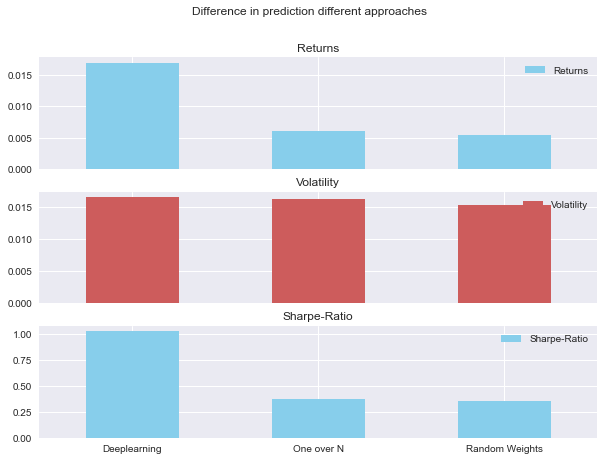

In [158]:
ax = df1.plot.bar(color=["SkyBlue","IndianRed"], rot=0, 
                 title="Difference in prediction different approaches", subplots = True, figsize = (10, 7))
plt.show()

In [56]:
# Error in price prediction

abs_error = pred_ret - actual_ret
print("Absolute error: ")
print(abs_error)
print("")
rel_error = abs(abs_error / actual_ret)
print("Relative error: ")
print(rel_error)

Absolute error: 
SKA-B.ST     0.000530
EKTA-B.ST    0.011994
GETI-B.ST   -0.025894
ERIC-B.ST    0.004508
TEL2-B.ST   -0.003427
HM-B.ST      0.017062
dtype: float64

Relative error: 
SKA-B.ST     0.205601
EKTA-B.ST    2.701826
GETI-B.ST    1.280165
ERIC-B.ST    0.853649
TEL2-B.ST    0.167029
HM-B.ST      1.557211
dtype: float64


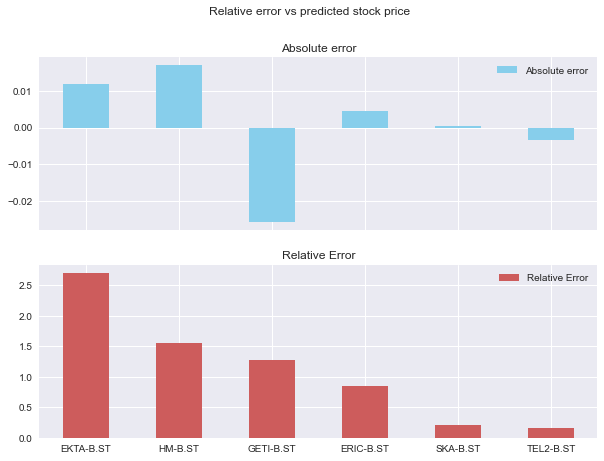

In [152]:
df = pd.DataFrame({"Absolute error":abs_error, "Relative Error":rel_error})
sorted_df = df.sort_values(by = ['Relative Error'], ascending=False)
ax = sorted_df.plot.bar(color=["SkyBlue","IndianRed", "Blueviolet", "Darkcyan"], rot=0, title="Relative error vs predicted stock price", subplots = True, figsize = (10, 7))
plt.show()

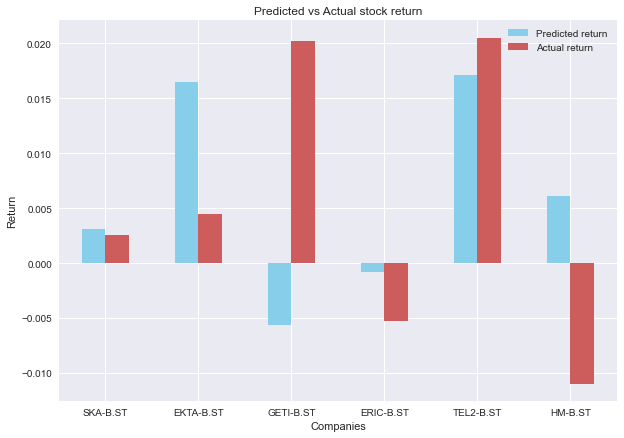

In [156]:
df = pd.DataFrame({"Predicted return":pred_ret,"Actual return":actual_ret})
sorted_df = df.sort_values(by = ['Predicted return'], ascending=False)
ax = df.plot.bar(color=["SkyBlue","IndianRed"], rot=0, title="Predicted vs Actual stock return", figsize = (10, 7))
ax.set_xlabel("Companies")
ax.set_ylabel("Return")
plt.show()

### Graphs of how the optimization looked like with backtracking

In [33]:
actual_ret = (unknown_price - actual_last) / actual_last

In [38]:
actual_portfolio = portfolio_optimizer(actual_ret, daily_cov)

In [39]:
no_pred = actual_portfolio.optimizer()

Max Sharpe Optimization terminated successfully

The return, volatility and Sharpe-Ratio are: [0.02  0.016 1.244]

           Maximum Sharpe Weights
SKA-B.ST                    0.000
EKTA-B.ST                   0.000
GETI-B.ST                   0.259
ERIC-B.ST                   0.000
TEL2-B.ST                   0.741
HM-B.ST                     0.000

Min Variance Optimization terminated successfully

The return, volatility and Sharpe-Ratio are: [0.005 0.016 0.323]

           Minimum Variance Weights
SKA-B.ST                      0.167
EKTA-B.ST                     0.167
GETI-B.ST                     0.167
ERIC-B.ST                     0.167
TEL2-B.ST                     0.167
HM-B.ST                       0.167


0.02044330809495536


/Users/antonerlandsson/.local/lib/python3.8/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


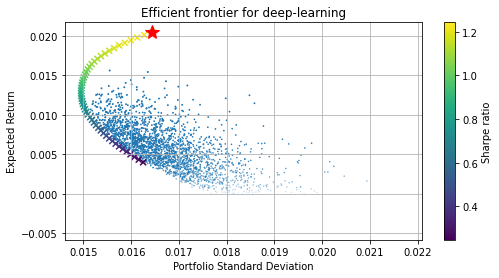

In [40]:
actual_portfolio.graph_efficient_frontier()

In [69]:
no_pred = actual_portfolio.optimizer(no_info=True)

In [70]:
one_over_n_nopred = actual_portfolio.one_over_n(no_info=False)

The return, volatility and Sharpe-Ratio are: [0.00526486 0.01628103 0.32337356]



In [71]:
random_weights_nopred = actual_portfolio.random_optimizer(no_info=False)

The return, volatility and Sharpe-Ratio are: [0.00974538 0.01537108 0.63400753]



In [83]:
df2 = pd.DataFrame([no_pred, one_over_n_nopred, random_weights_nopred], 
                  columns = ['Returns', 'Volatility', 'Sharpe-Ratio'], 
                  index = ['Known prices', 'One over N', 'Random Weights'])

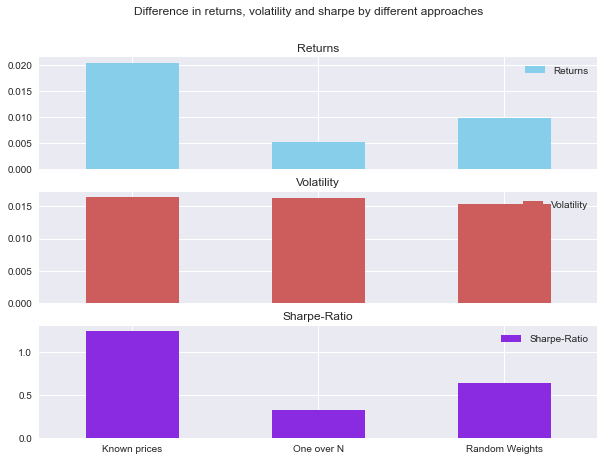

In [133]:
ax = df2.plot.bar(color=["SkyBlue","IndianRed", "Blueviolet"], rot=0, 
                 title="Difference in returns, volatility and sharpe by different approaches", subplots = True, figsize = (10, 7))

plt.show()

### Showing the difference between approaches

In [128]:
df3 = pd.DataFrame([no_pred, one_over_n_nopred, random_weights_nopred, deep_learning, one_over_n, random_weights], 
                  columns = ['Returns', 'Volatility', 'Sharpe-Ratio'], 
                  index = ['Known prices maximize sharpe', '1overN Known prices', 'Random Weights Known Prices', 'LSTM predicted maximize sharpe', '1overN LSTM', 'Random Weights LSTM'])

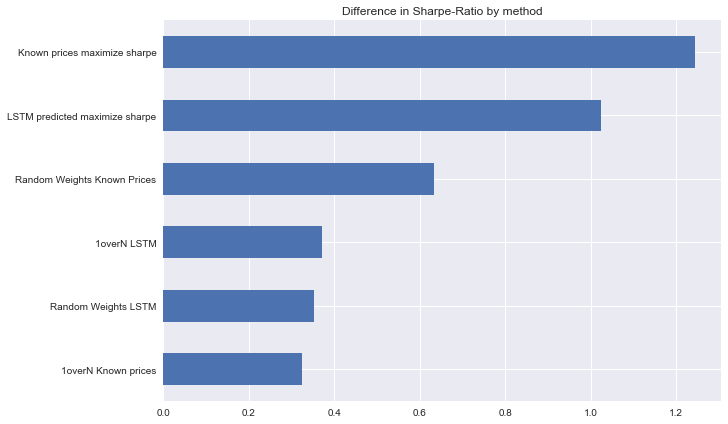

In [129]:
test = df3.sort_values(by = ['Sharpe-Ratio'], axis = 0, ascending = True)

ax = test['Sharpe-Ratio'].plot.barh(rot=0, 
                 title="Difference in Sharpe-Ratio by method", figsize = (10, 7))